In [1]:
import os
import pandas as pd
from scipy.misc import imread
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
%matplotlib inline

def get_df_faces(directory0, directory1, preprocessing = False):
    imgs0 = list()
    for filename in os.listdir(directory0):
        if filename.endswith(".jpg"):
            img = cv2.imread(directory0 + filename, 0)
            if preprocessing:
                autocontrast(img, white_perc=0., black_perc = 0.)
                img = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(3, 3), visualise=False)
            imgs0.append(img) 
        else:
            continue
    imgs1 = list()
    for filename in os.listdir(directory1):
        if filename.endswith(".jpg"):
            img = cv2.imread(directory1 + filename, 0)
            if preprocessing:
                autocontrast(img, white_perc=0., black_perc = 0.)
                img = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(3, 3), visualise=False)
            imgs1.append(img) 
        else:
            continue
    Y_closed = np.full((1, len(imgs0)), 0)
    Y_opened = np.full((1, len(imgs1)), 1)
    return np.array(imgs0 + imgs1, dtype=np.float32), np.hstack((Y_closed, Y_opened))

In [2]:
from operator import itemgetter
def autocontrast(image, white_perc=0., black_perc = 0.):
    img = image
    sorted_img = sorted(np.ndenumerate(img), key=itemgetter(1))
    pixels_number = len(sorted_img)
    black_border = float(black_perc)*pixels_number
    white_border = float(white_perc)*pixels_number
    for e in enumerate(sorted_img):
        if (int(round(black_border)) <= e[0] and 
           (e[0] == 0 or e[0] == pixels_number - 1 or img[e[1][0]] != sorted_img[e[0] + 1][1])):
            black_threshold_number = e[0]
            break
        else:
            img[e[1][0]] = 0
    reversed_sorted_img = list(reversed(sorted_img))
    for e in enumerate(reversed_sorted_img):
        if (int(round(white_border)) <= e[0] and 
           (e[0] == 0 or e[0] == pixels_number - 1 or img[e[1][0]] != reversed_sorted_img[e[0] + 1][1])):
            white_threshold_number = pixels_number - e[0] - 1
            break
        else:
            img[e[1][0]] = 255
    black_threshold = sorted_img[black_threshold_number][1]
    white_threshold = sorted_img[white_threshold_number][1]

    for e in enumerate(sorted_img[black_threshold_number : white_threshold_number + 1]):
        img[e[1][0]] = (img[e[1][0]] - black_threshold)*255 / float(white_threshold - black_threshold)
    return img


In [7]:
X, Y = get_df_faces("dataset_B_FacialImages/ClosedFace/", "dataset_B_FacialImages/OpenFace/", True)

# Faces dataset score

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#pixels_per_cell=(4, 4), cells_per_block=(3, 3)
clf = LogisticRegression()
params = {'C' : [0.001, 0.01, 0.1, 1, 10, 100], 'penalty' : ['l1', 'l2']}
gs = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=2, cv=10, verbose=1)
gs.fit(X,*Y)
print("accuracy: ", gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:  8.6min finished


('accuracy: ', 0.89145687164671894)
{'penalty': 'l2', 'C': 1}


In [16]:
clf = LogisticRegression()
#pixels_per_cell=(4, 4), cells_per_block=(3, 3)
params = {'C' : [1], 'penalty' : ['l2']}
gs = GridSearchCV(clf, param_grid=params, scoring='roc_auc', n_jobs=2, cv=10, verbose=1)
gs.fit(X,*Y)
print("roc_auc: ", gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.3min finished


('roc_auc: ', 0.95359393420883454)
{'penalty': 'l2', 'C': 1}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
#pixels_per_cell=(4, 4), cells_per_block=(2, 2)
params = {'n_estimators' : [100, 150, 250, 300]}
gs = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
gs.fit(X,*Y)
print("accuracy: ", gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.2min finished


('accuracy: ', 0.89145687164671894)
{'n_estimators': 250}


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
#pixels_per_cell=(4, 4), cells_per_block=(2, 2)
params = {'n_estimators' : [10, 30, 50, 100, 150]}
gs = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
gs.fit(X,*Y)
print("accuracy: ", gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000, svd_solver='randomized').fit(X)
X_pca = pca.transform(X)
print(X_pca.shape)

(2423, 1000)


In [41]:
from xgboost import XGBClassifier
clf = XGBClassifier()
#pixels_per_cell=(4, 4), cells_per_block=(2, 2)
params = {'n_estimators' : np.arange(200, 1000, 50)}
gs = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, cv=3, verbose=1)
gs.fit(X_pca,*Y)
print("accuracy: ", gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 13.0min finished


('accuracy: ', 0.81923235658274862)
{'n_estimators': 800}


# Eye detection

In [44]:

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [ ]:
img = X[500].astype(np.uint8)
gray = img#cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eyes = eyes_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in eyes:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(img)

In [46]:
cv2.imshow?

# Wavelet transform(reduction)

In [5]:
import pywt

In [175]:
def get_df_faces_wt(directory0, directory1):
    imgs0 = list()
    for filename in os.listdir(directory0):
        if filename.endswith(".jpg"):
            img = cv2.imread(directory0 + filename, 0)
            dwt = pywt.dwt2(img, 'haar')
            img = np.array(dwt[0] + dwt[1][0] + dwt[1][1] + dwt[1][2])
            img = dwt[1][1]
            img = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualise=False)
            #img = np.reshape(img, (img.shape[0]*img.shape[1])).tolist()
            imgs0.append(img) 
        else:
            continue
    imgs1 = list()
    for filename in os.listdir(directory1):
        if filename.endswith(".jpg"):
            img = cv2.imread(directory1 + filename, 0)
            dwt = pywt.dwt2(img, 'haar')
            img = np.array(dwt[0] + dwt[1][0] + dwt[1][1] + dwt[1][2])
            img = dwt[1][1]
            img = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualise=False)
            #img = np.reshape(img, (img.shape[0]*img.shape[1])).tolist()
            imgs1.append(img)
        else:
            continue
    Y_closed = np.full((1, len(imgs0)), 0)
    Y_opened = np.full((1, len(imgs1)), 1)
    return np.array(imgs0 + imgs1, dtype=np.float32), np.hstack((Y_closed, Y_opened))

In [173]:
X, Y = get_df_faces_wt("dataset_B_FacialImages/ClosedFace/", "dataset_B_FacialImages/OpenFace/")

In [ ]:
hog

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
params = {'C' : [0.001, 0.01, 0.1, 1.], 'penalty' : ['l1', 'l2']}
gs = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, cv=10, verbose=1)
gs.fit(X,*Y)
print("accuracy: ", gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished


('accuracy: ', 0.85596368138671064)
{'penalty': 'l1', 'C': 0.001}


# Wavelets-hog visualisation

In [3]:
X, Y = get_df_faces("dataset_B_FacialImages/ClosedFace/", "dataset_B_FacialImages/OpenFace/", False)

/home/navi/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((1, 1192), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/navi/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((1, 1231), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


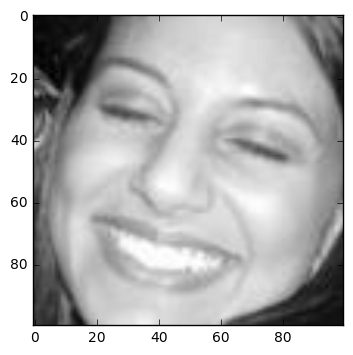

In [61]:
i = 15
dwt = pywt.dwt2(X[i], 'haar')
hog_img = hog(X[i], orientations=8, pixels_per_cell=(4, 4), cells_per_block=(3, 3), visualise=True)
plt.imshow(X[i], cmap='gray')

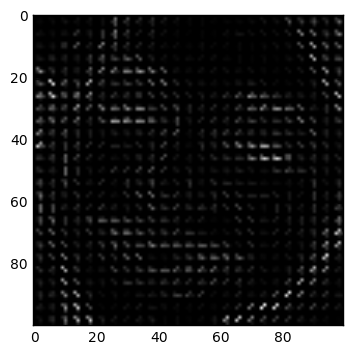

In [62]:
plt.imshow(hog_img[1], cmap='gray')

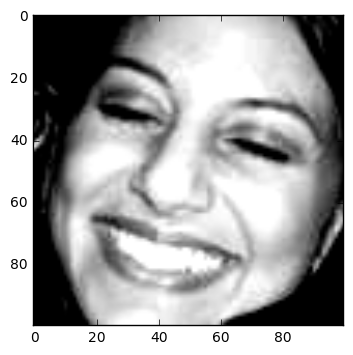

In [66]:
plt.imshow(autocontrast(X[i], 0., 0.2), cmap='gray')

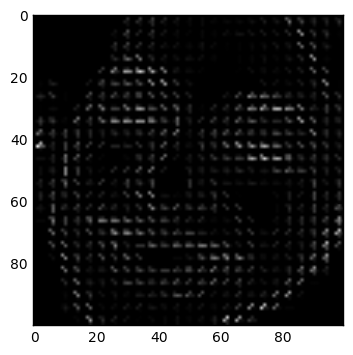

In [67]:
hog_img = hog(X[i], orientations=8, pixels_per_cell=(4, 4), cells_per_block=(3, 3), visualise=True)
plt.imshow(hog_img[1], cmap='gray')

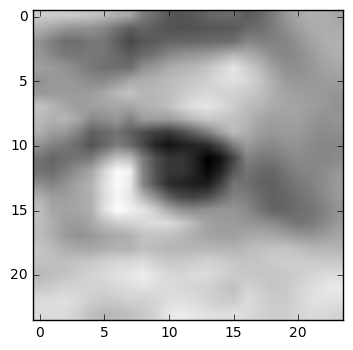

In [55]:
n = 12
shrinked_coeff = (coeffs[0][:n,:n],(coeffs[1][0][:n,:n], coeffs[1][1][:n,:n], coeffs[1][2][:n,:n]))
plt.imshow(pywt.idwt2(shrinked_coeff , 'haar'), cmap="gray")

In [ ]:
cv2.